# 1.  Data Exploration & Preprocessing

In [1]:
# setup from activity V
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.19.0
NumPy version:      2.0.2

✅ GPU available: /physical_device:GPU:0


In [2]:
!pip install -q kagglehub
import kagglehub

# set dataset path and data dir (local)
# data_dir = '../data'
dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue

# Find the directory with exactly 4 class subfolders containing images
data_dir = None
for root, dirs, files in os.walk(dataset_path):
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    if len(dirs) == 4:
        has_images = False
        for d in dirs:
            subpath = os.path.join(root, d)
            img_files = [f for f in os.listdir(subpath)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if len(img_files) > 10:
                has_images = True
                break
        if has_images:
            data_dir = root
            break

if data_dir is None:
    raise FileNotFoundError("Could not find class folders. Check the structure above.")

print(f"\n✅ Data directory: {data_dir}")
for d in sorted(os.listdir(data_dir)):
    sub = os.path.join(data_dir, d)
    if os.path.isdir(sub):
        n = len([f for f in os.listdir(sub) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"   - {d}: {n} images")

100%|██████████| 21.8M/21.8M [00:00<00:00, 99.9MB/s]

Extracting files...



Dataset structure:
1/  (0 files)
  data/  (0 files)
    green_area/  (1500 files)
    cloudy/  (1500 files)
    water/  (1500 files)
    desert/  (1131 files)

✅ Data directory: /root/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1/data
   - cloudy: 1500 images
   - desert: 1131 images
   - green_area: 1500 images
   - water: 1500 images


In [3]:
# Load images into TensorFlow datasets
IMG_SIZE = 256
BATCH_SIZE = 32

# four image classes: 'cloudy', 'desert', 'green_area', 'water'
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Use 'categorical' for multi-class classification
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [4]:
# image class names
class_names = train_ds.class_names

# Count images per class
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    n_images = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"  {class_name}: {n_images} images")

  cloudy: 1500 images
  desert: 1131 images
  green_area: 1500 images
  water: 1500 images


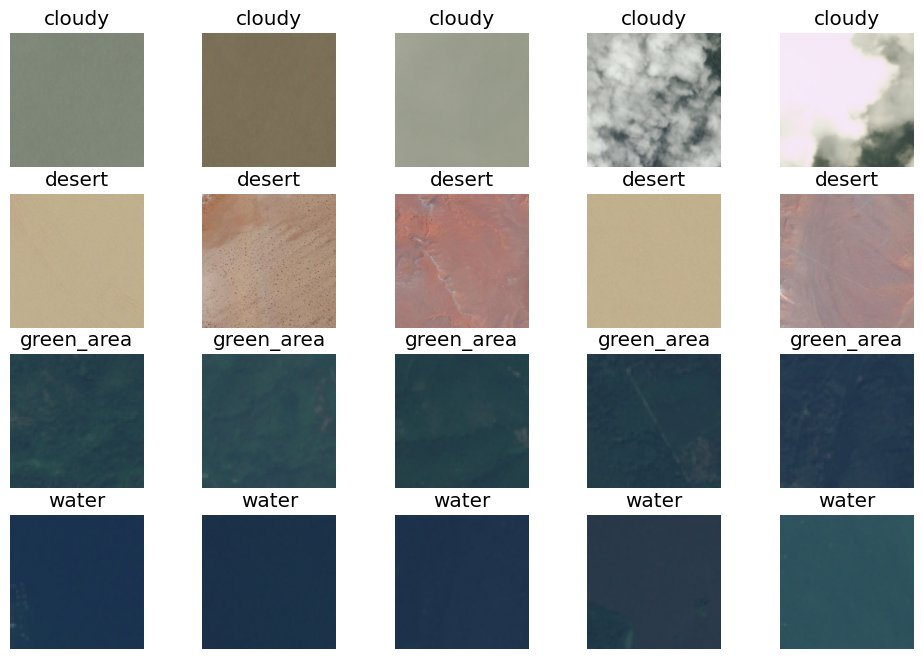

In [5]:
# plot num images from each class
num = 5
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(num, len(image_files)))

    for j, img_file in enumerate(selected_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)
        plt.subplot(len(class_names), num, i * num + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')

In [6]:
# image properties from activity V
# Inspect image properties from each class
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        img_path = os.path.join(class_path, random.choice(image_files))
        img = plt.imread(img_path)
        print(f"{class_name}: shape={img.shape}, dtype={img.dtype}, min={img.min()}, max={img.max()}")

cloudy: shape=(256, 256, 4), dtype=uint8, min=128, max=255
desert: shape=(256, 256, 3), dtype=uint8, min=133, max=203
green_area: shape=(64, 64, 3), dtype=uint8, min=27, max=88
water: shape=(64, 64, 3), dtype=uint8, min=85, max=132


In [7]:
# varying image sizes, resize and normalize
resize_and_normalize = keras.Sequential([
    layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]
    layers.Resizing(IMG_SIZE, IMG_SIZE)  # Resize to (256, 256)
])

# Apply the preprocessing to the datasets
train_ds = train_ds.map(lambda x, y: (resize_and_normalize(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_normalize(x), y))

# print resulting sizes
for image_batch, labels_batch in train_ds:
    print("Image batch shape:", image_batch.shape)

Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
Image batch shape: (32, 256, 256, 3)
I

## Data Quality and Imbalances

Images are resized to 256x256. Water/green_area is 64x64 and cloudy/desert is 256x256 so there will be artifacts when resized.

Desert class also has less images than the other classes at 1131 images rather than 1500.

Some cloudy or desert images also have odd image artifacts of banding where the colors suddenly change.

# 2. Baseline CNN (No Augmentation)

In [8]:
# Helper functions from activity V

# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline optimized")

def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n📊 Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   ⚠️  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   ⚡ Moderate gap — some overfitting")
    else:
        print(f"   ✅ Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    """Show model predictions on sample images."""
    plt.figure(figsize=(16, 4))
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            pred_prob = predictions[i][0]
            pred_label = 1 if pred_prob > 0.5 else 0
            true_label = int(labels[i].numpy())
            color = 'green' if pred_label == true_label else 'red'
            plt.title(f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                     fontsize=9, color=color, fontweight='bold')
            plt.axis('off')
    plt.suptitle('Predictions (Green=Correct, Red=Wrong)', fontweight='bold')
    plt.tight_layout()
    plt.show()

✅ Data pipeline optimized


In [9]:
# basic model architecture

model_basic = models.Sequential([
    # Add Rescaling layer (normalize pixels to 0-1)
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Conv Block 1 — Conv2D(32 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # Conv Block 2 — Conv2D(64 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # Conv Block 3 — Conv2D(128 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # Classification head — Flatten, Dense(128, relu), Dense(1, softmax)
    # softmax for multiclassification
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes: cloudy, desert, green_area, water

])

# Display the architecture
model_basic.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow._api.v2.config import optimizer

model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 15

history_basic = model_basic.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.6112 - loss: 0.8108 - val_accuracy: 0.7602 - val_loss: 0.3807
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7992 - loss: 0.3706 - val_accuracy: 0.7522 - val_loss: 0.4410
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8058 - loss: 0.3660 - val_accuracy: 0.7895 - val_loss: 0.3483
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8154 - loss: 0.3266 - val_accuracy: 0.8606 - val_loss: 0.3116
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8146 - loss: 0.3274 - val_accuracy: 0.7531 - val_loss: 0.3439
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7858 - loss: 0.3800 - val_accuracy: 0.7993 - val_loss: 0.3449
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8134 - loss: 0.3229 - val_accuracy: 0.8694 - val_loss: 0.2979
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8197 - loss: 0.3261 -

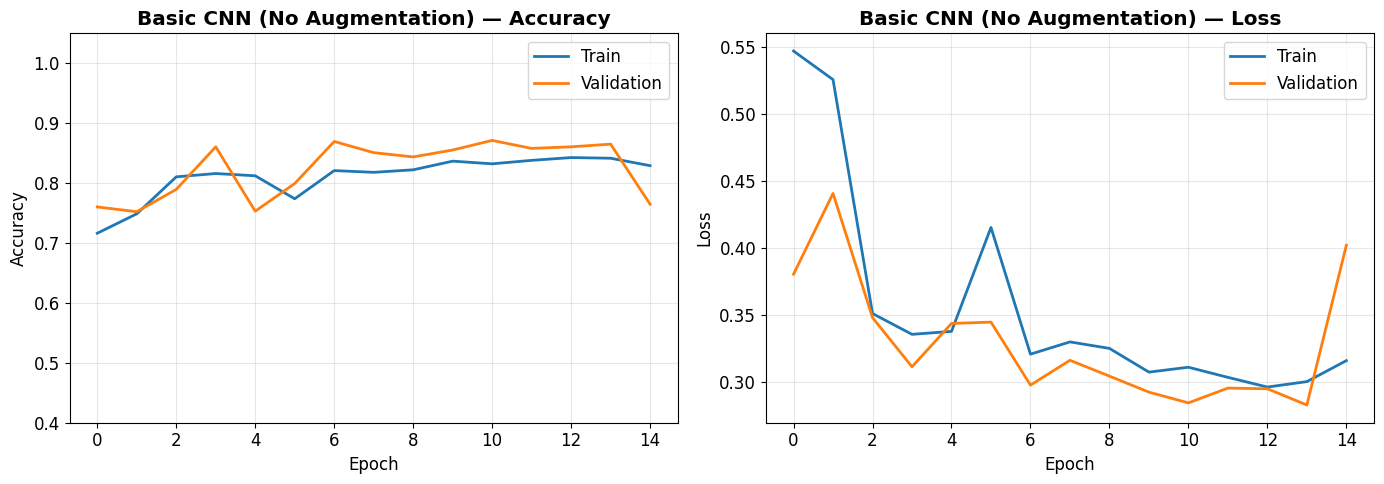


📊 Final Results:
   Train Accuracy:      0.8291 (82.9%)
   Validation Accuracy: 0.7647 (76.5%)
   Gap (overfit check): 0.0644 (6.4%)
   ⚡ Moderate gap — some overfitting


In [11]:
# plot curves
plot_training_curves(history_basic, title='Basic CNN (No Augmentation)')

In [12]:
from sklearn.metrics import classification_report

# Get true labels and predictions for the validation set
val_labels = []
val_predictions = []

for images, labels in val_ds:
    val_labels.extend(np.argmax(labels.numpy(), axis=1)) # Convert one-hot to class index
    val_predictions.extend(np.argmax(model_basic.predict(images, verbose=0), axis=1)) # Get predicted class index

# Generate classification report
report = classification_report(val_labels, val_predictions, target_names=class_names)
print(report)


              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      0.96      0.98       224
  green_area       0.65      0.42      0.51       318
       water       0.56      0.78      0.65       317

    accuracy                           0.76      1126
   macro avg       0.80      0.79      0.78      1126
weighted avg       0.78      0.76      0.76      1126



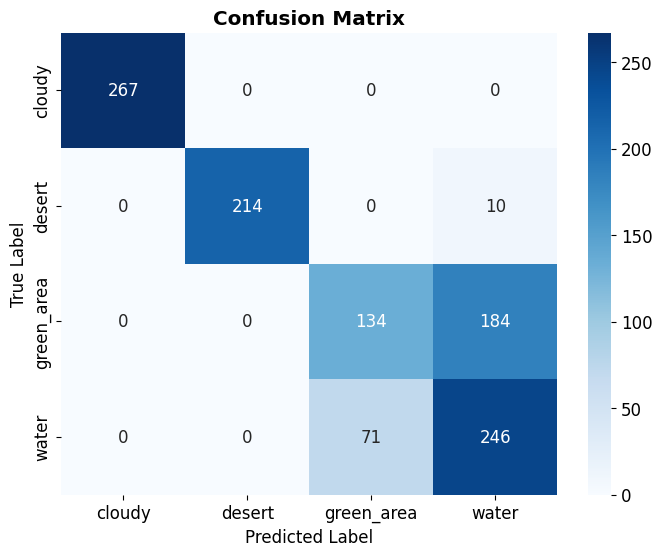

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()